In [1]:
import numpy as np
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import sklearn.neighbors as knn
import and_logic_generator as and_gen
import utils
import applicability_domain as ad
import adversarial_generator as adversarial


In [2]:
# Repeatable seed
random_state = 2**12
np.random.seed(seed=random_state)


In [3]:
# Creating samples
n = 1000
x, y = and_gen.generate_samples(1000, random_state=random_state)


In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)


[12.  8.]


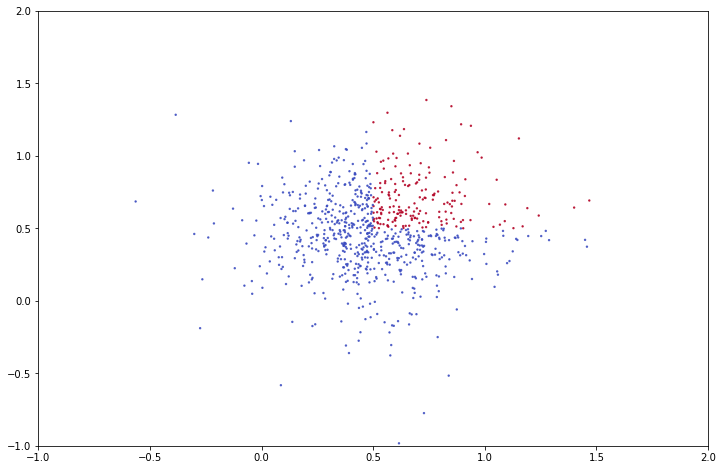

In [5]:
import matplotlib.pyplot as plt
figsize = np.array(plt.rcParams["figure.figsize"]) * 2
print(figsize)

x_min, x_max = -1.0, 2

plt.figure(figsize=figsize.tolist())
plt.scatter(
    x_train[:, 0], x_train[:, 1], marker='.', c=y_train, alpha=0.8, 
    cmap='coolwarm', s=8, edgecolor='face')
plt.grid(False)
plt.xlim(x_min, x_max)
plt.ylim(x_min, x_max)
plt.show()


In [6]:
# SVM
gamma, c = 10.0, 1000

model_svm = svm.SVC(
    kernel='rbf', random_state=random_state, gamma=gamma, C=c)
model_svm.fit(x_train, y_train)


SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=10.0, kernel='rbf',
    max_iter=-1, probability=False, random_state=4096, shrinking=True,
    tol=0.001, verbose=False)

In [7]:
y_train_pred = model_svm.predict(x_train)
score = accuracy_score(y_train, y_train_pred)
print(f'Accuracy on train set = {score*100:.4f}%')

y_test_pred = model_svm.predict(x_test)
score = accuracy_score(y_test, y_test_pred)
print(f'Accuracy on test set  = {score*100:.4f}%')


Accuracy on train set = 99.3750%
Accuracy on test set  = 97.5000%


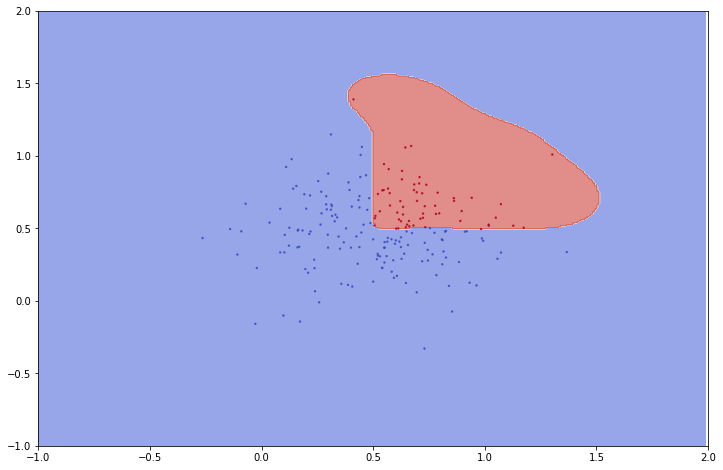

In [8]:
h = .01

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(x_min, x_max, h))
Z = model_svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=figsize.tolist())
plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.6)
plt.scatter(
    x_test[:, 0], x_test[:, 1], c=y_test_pred, marker='.', alpha=0.8,
    cmap='coolwarm', s=8, edgecolor='face')
plt.xlim(x_min, x_max)
plt.ylim(x_min, x_max)
plt.show()


In [9]:
model_svm.get_params()


{'C': 1000,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 10.0,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 4096,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [10]:
ind_train_c1 = np.where(y_train == 1)
x_train_c1 = x_train[ind_train_c1]
y_train_c1 = np.ones(len(x_train_c1))
mu_train_c1 = np.mean(x_train_c1, axis=0)

ind_train_c0 = np.where(y_train == 0)
x_train_c0 = x_train[ind_train_c0]
y_train_c0 = np.zeros(len(x_train_c0))
mu_train_c0 = np.mean(x_train_c0, axis=0)

print(f'Positive mean = [{mu_train_c1[0]:.4f}, {mu_train_c1[1]:.4f}]')
print(f'Negative mean = [{mu_train_c0[0]:.4f}, {mu_train_c0[1]:.4f}]')


Positive mean = [0.7055, 0.7160]
Negative mean = [0.4438, 0.4232]


In [11]:
# Generating Adversarial Examples from test set
# This implementation uses multiple iterations to update x, until all of them
# match the target classes.
epsilon = 0.0006

adversarial_examples = np.copy(x_test)  # make a clone
pred = model_svm.predict(x_test)
targets = and_gen.get_not_y(y_test)

epoch = 1
while np.array_equal(pred, targets) == False:
    adversarial_examples = adversarial.moving_mean(
        x=adversarial_examples,
        y=pred,
        targets=targets,
        means={0: mu_train_c0, 1: mu_train_c1},
        epsilon=epsilon,
        verbose=0,
        epoch=epoch)
    pred = model_svm.predict(adversarial_examples)
    epoch += 1

print(f'Completed after {epoch} epoch.')


Completed after 1386 epoch.


In [12]:
# Results
original_pred = model_svm.predict(x_test)
pred_ae = model_svm.predict(adversarial_examples)
y_ae = and_gen.get_y(adversarial_examples)

for xx, ae, p, p_ae, yy_ae in zip(
        x_test, 
        adversarial_examples, 
        original_pred, 
        pred_ae, 
        y_ae):
    if p != p_ae:
        print(f'from [{xx[0]: .4f}, {xx[1]: .4f}] = {p} to ' +
        f'[{ae[0]: .4f}, {ae[1]: .4f}] = {p_ae}; True y = {yy_ae}')

matches = np.equal(y_ae, pred)
count = len(matches[matches==False])
print(f'\nFound {count} Adversarial Examples out of ' +
    f'{len(y_ae)}. {count / len(y_ae) * 100.0:.4f}% successful rate')


from [ 0.9925,  0.4146] = 0 to [ 0.9097,  0.4974] = 1; True y = 0
from [ 0.2171,  0.7270] = 0 to [ 0.4979,  0.7162] = 1; True y = 0
from [ 0.8108,  0.4187] = 0 to [ 0.7268,  0.5027] = 1; True y = 1
from [ 0.6517,  0.5258] = 1 to [ 0.6229,  0.4970] = 0; True y = 0
from [ 0.8257,  0.4825] = 0 to [ 0.8059,  0.5023] = 1; True y = 1
from [ 0.5816,  0.4246] = 0 to [ 0.6566,  0.4996] = 1; True y = 0
from [ 0.6240,  0.3711] = 0 to [ 0.7056,  0.5019] = 1; True y = 1
from [ 0.1033,  0.4553] = 0 to [ 0.4975,  0.7163] = 1; True y = 0
from [ 0.6150,  0.5613] = 1 to [ 0.5478,  0.4941] = 0; True y = 0
from [ 0.4338,  0.6951] = 0 to [ 0.4974,  0.7155] = 1; True y = 0
from [ 0.7810,  0.6000] = 1 to [ 0.6814,  0.5004] = 0; True y = 1
from [ 0.4676,  0.8665] = 0 to [ 0.4946,  0.8395] = 1; True y = 0
from [ 0.6291,  0.8964] = 1 to [ 0.4965,  0.7638] = 0; True y = 0
from [ 0.2082,  0.1938] = 0 to [ 0.5178,  0.5034] = 1; True y = 1
from [ 0.5663,  0.7746] = 1 to [ 0.4973,  0.7056] = 0; True y = 0
from [ 0.2

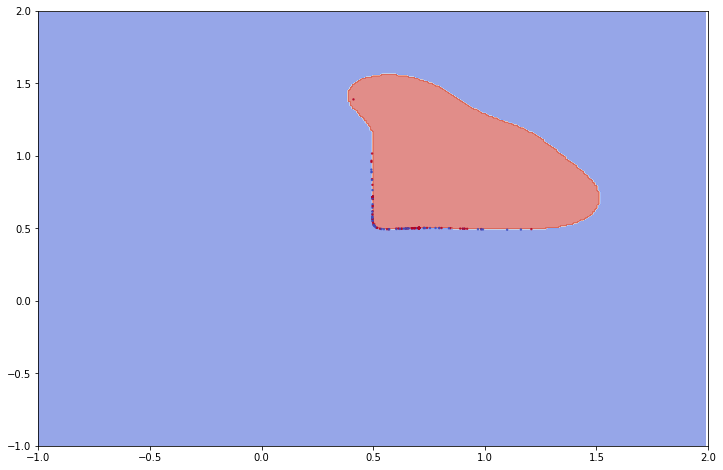

In [13]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(x_min, x_max, h))
Z = model_svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=figsize.tolist())
plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.6)
plt.scatter(
    adversarial_examples[:, 0], adversarial_examples[:, 1], 
    c=pred_ae, marker='.', alpha=0.8, cmap='coolwarm', s=8, edgecolor='face')
plt.xlim(x_min, x_max)
plt.ylim(x_min, x_max)
plt.show()
